In [1]:
from seaborn import palettes
import nibabel as nib
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import cb_tools
from pygam import LinearGAM
import subprocess
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats import anova
from statsmodels.stats import multitest
from scipy import stats
import pickle
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mtick

In [2]:
# set results path
results_dir = '/nfs/s2/userhome/liuxingyu/workingdir/cerebellum_grad_dev_v2'
index = 't1wT2wRatio'  # ['t1wT2wRatio', 'fALFF']

In [3]:
atlas_dir = os.path.join(os.getcwd(), 'atlas')
template_mni_2mm_path = os.path.join(atlas_dir, 'MNI152_T1_2mm_brain.nii.gz')
cb_mask_mni_path = os.path.join(atlas_dir,'Cerebellum-MNIfnirt-maxprob-thr25.nii')

cb_mask = nib.load(cb_mask_mni_path).get_fdata()
cb_mask = cb_mask.astype(np.bool)

In [4]:
index_dir = os.path.join(results_dir, index)
sub_adult = pd.read_csv(os.path.join(results_dir, 'sub_adult'), header=0, dtype={'Sub': np.str})
sub_dev = pd.read_csv(os.path.join(results_dir, 'sub_dev'), header=0, dtype={'Sub': np.str})
num_str_col = 6

# ---------------------
# prepare atlas

num_roi = 11
atlas_cb = {'t1wT2wRatio' : 'cb_acapulco_adult', 'fALFF' : 'cb_acapulco_adult-2mm'}
atlas_cb_voxel = 'cb_acapulco_adult-2mm'
atlas = cb_tools.atlas_load(atlas_cb[index], atlas_dir)
palette_cb = sns.color_palette('plasma', num_roi)

# num_roi = 7
# atlas_cb = {'t1wT2wRatio' : 'cb_acapulco_pediatric', 'fALFF' : 'cb_acapulco_pediatric-2mm'}
# atlas = cb_tools.atlas_load(atlas_cb[index], atlas_dir)
# palette_cb = sns.color_palette('plasma', num_roi)

# num_roi = 10
# atlas_cb = {'t1wT2wRatio' : 'cb_anat_fsl', 'fALFF' : 'cb_anat_fsl'}
# # atlas_cb = {'t1wT2wRatio' : 'cb_fsl', 'fALFF' : 'cb_fsl'}
# atlas = cb_tools.atlas_load(atlas_cb[index], atlas_dir)
# palette_cb = sns.diverging_palette(230,230, l=80, center='dark', n=len(atlas.label_info['lobule'][:20:2]))

# num_roi = 6
# atlas_cb = {'t1wT2wRatio' : 'cb_func_7nw', 'fALFF' : 'cb_func_7nw'}
# atlas = cb_tools.atlas_load(atlas_cb[index], atlas_dir)
# palette_cb = sns.color_palette([tuple(atlas.label_info['color'][i] / 255) for i in [0,1,2,3,5,6]])

# prepare roi data
data_roi = pd.read_csv(os.path.join(index_dir, f'{index}_{atlas_cb[index]}_roi.csv'))
data_roi = data_roi.astype({'Sub': np.str})
data_adult_roi = data_roi.merge(sub_adult, on='Sub', how='inner')
data_dev_roi = data_roi.merge(sub_dev, on='Sub', how='inner')

# age thr
data_dev_roi = data_dev_roi[data_dev_roi['Age_in_years'] < 20]
data_dev_roi = data_dev_roi[data_dev_roi['Age_in_years'] > 8]
data_dev_roi = data_dev_roi.reset_index(drop=True)

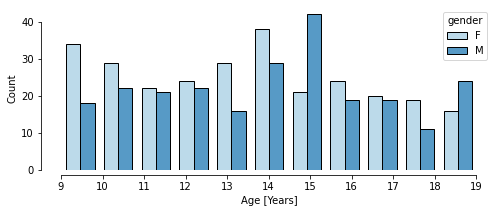

In [5]:
plt.figure(figsize=[8,3])
sns.histplot(x='Age_in_years', hue='gender', multiple='dodge', shrink=0.75, data=data_dev_roi, palette='Paired')
plt.xticks(range(9,20,1))
plt.xlabel('Age [Years]')
sns.despine(offset=5, trim=True)

In [6]:
# roi results
def hemi_merging(x, num_str_col):
    # hemi
    x_l = x[[x.columns[i] for i in range(x.shape[-1]) if x.columns[i].split('_')[-1]=='l']]
    x_l.rename(columns=lambda x: f'{x.split("_")[0]}', inplace=True)
    
    x_r = x[[x.columns[i] for i in range(x.shape[-1]) if x.columns[i].split('_')[-1]=='r']]   
    x_r.rename(columns=lambda x: f'{x.split("_")[0]}', inplace=True)

    other_col = [i for i in x.columns if i.split('_')[-1] not in ['l', 'r', 'Vermis']]
    x_merged = pd.concat([pd.concat([x_l,x_r]).mean(level=0), x[other_col]], axis=1)

    return x_merged

if atlas_cb[index] != 'cb_func_7nw':
    dev = hemi_merging(data_dev_roi, num_str_col)
    adult = hemi_merging(data_adult_roi, num_str_col)
    lobule_name = atlas.label_info['lobule'][:num_roi*2:2]
else:
    dev = copy.deepcopy(data_dev_roi)
    dev = dev.drop('5-limbic', 1)
    adult = copy.deepcopy(data_adult_roi)
    adult = adult.drop('5-limbic', 1)
    lobule_name = dev.columns[:-num_str_col]

/nfs/s2/userhome/liuxingyu/.conda/envs/local/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


         F Value  Num DF  Den DF  Pr > F
roi  4503.212138    10.0  9790.0     0.0


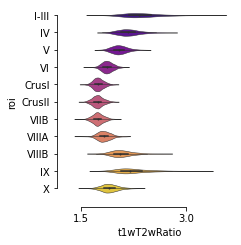

In [7]:
# Fig. 1c and Fig. 2b
# violin plot of cb lobules
data = copy.deepcopy(adult)
iqr = 3  # 1.5

# threshold, remove outliers outside x IQR
data.loc[:,data.columns[:-num_str_col]] = cb_tools.thr_IQR(
    data.loc[:,data.columns[:-num_str_col]].values, times=iqr, series=True)
data = data.dropna()

# data stack
data_stack = pd.melt(data, id_vars=data.columns[-num_str_col:], 
                     var_name=['lobule'], value_vars=data.columns[:-num_str_col], value_name=index)
# data_stack = pd.concat([data_stack, data_stack['lobule'].str.split('_',expand=True).rename(columns={0:'roi',1:'hemi'})], axis=1)
data_stack['roi'] = data_stack['lobule']

# plot
row = 'roi'
value = index
row_order = lobule_name
sort_roi_by_index = False

if sort_roi_by_index:
    sort_index = np.argsort(-1 * data_stack.groupby('roi').mean()[index])
    row_order = row_order[sort_index]
    palette_cb = [palette_cb[i] for i in sort_index]

fig, ax = plt.subplots(figsize=(3, 3.5))
sns.violinplot(x=value, y=row, palette=palette_cb, order=row_order, 
                linewidth=0.5, data=data_stack, ax=ax)  # fliersize=1, cut=0, bw=.2, whis=3, 

ax.set_xticks((1.5, 3.0))  # anat: [1.5, 3],  func: [0.08, 0.15]
# ax.tick_params(colors='gray', which='both')
sns.despine(offset=10, trim=True, ax=ax)

# # stats
gradient_stats = anova.AnovaRM(data=data_stack, depvar=index, subject='Sub', within=['roi']).fit()
print(gradient_stats.anova_table)

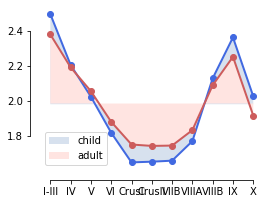

In [8]:
# Fig 1e
# average gradient in children and adults groups
iqr = 3  # 1.5

dev_mean = np.nanmean(cb_tools.thr_IQR(dev.loc[:,dev.columns[:-num_str_col]].values, times=iqr, series=True), 0)
adult_mean = np.nanmean(cb_tools.thr_IQR(adult.loc[:,adult.columns[:-num_str_col]].values, times=iqr, series=True), 0)

# plot
plt.figure(figsize=(4,3))
plt.plot(lobule_name, dev_mean, color='royalblue', marker='o', lw=2)
plt.fill_between(lobule_name, dev_mean, np.repeat(dev_mean.mean(), len(dev_mean)), 
                facecolor='lightsteelblue', alpha=0.5, label='child')

plt.plot(lobule_name, adult_mean, color='indianred', marker='o', lw=2)
plt.fill_between(lobule_name, adult_mean, np.repeat(adult_mean.mean(), len(adult_mean)), 
                facecolor='mistyrose', alpha=1, label='adult')
plt.legend()
sns.despine(offset=10, trim=True)

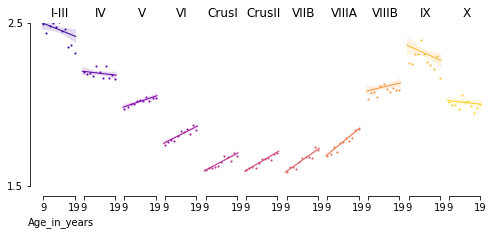

In [9]:
data = copy.deepcopy(dev)
data[data.columns[:-num_str_col]] = cb_tools.thr_IQR(data[data.columns[:-num_str_col]].values, times=1.5, series=True)
data_g = data.groupby(['Age_in_years']).median().loc[:, data.columns[:-num_str_col]]
# data stack

data_stack = pd.melt(data, id_vars=data.columns[-num_str_col:], 
                     var_name=['lobule'], value_vars=data.columns[:-num_str_col], value_name=index)

data_stack = pd.concat([data_stack, data_stack['lobule'].str.split('_',expand=True).rename(columns={0:'roi',1:'hemi'})], axis=1)
# -------------------------------
# plot 

fig, axes = plt.subplots(nrows=1, ncols=num_roi, figsize=[8, 3], sharex=True, sharey=True) 
fig.subplots_adjust(wspace=0)
for i, col in enumerate(data.columns[:num_roi]):
    sns.regplot(x=data['Age_in_months'] / 12, y=data[col], order=1, scatter=False, line_kws={'lw':1}, color=palette_cb[i], ax=axes[i])
    sns.scatterplot(x=data_g.index, y=data_g[col], s=5, marker='o', color=palette_cb[i], ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlim([8,21])
    axes[i].set_xticks([9, 19])
    axes[i].set_ylim([1.5, 2.5])
    axes[i].set_yticks([1.5, 2.5])
    axes[i].set_ylabel('')
    if i != 0:
        sns.despine(offset=10, trim=True, ax=axes[i], left=True)
        # axes[i].set_xticks([])
        # axes[i].set_yticks([])
        # axes[i].set_xticklabels([])
        axes[i].set_xlabel('')
        axes[i].tick_params(colors='w', which='both', axis='y')
    else:
        sns.despine(offset=10, trim=True, ax=axes[i])
        axes[i].set_xlabel('Age_in_years')

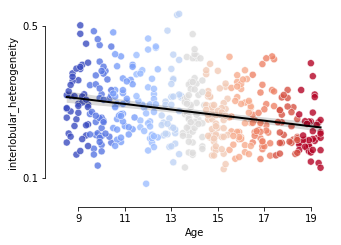

In [10]:
data = copy.deepcopy(dev)
data[data.columns[:-num_str_col]] = cb_tools.thr_IQR(data[data.columns[:-num_str_col]].values, times=1.5, series=True)
data_std = np.std(data[data.columns[:-num_str_col]].values, -1)
data_std = pd.DataFrame(data_std, columns=['interlobular_heterogeneity'])
data_std[data.columns[-num_str_col:]] = data[data.columns[-num_str_col:]]
data_std.dropna(inplace=True)
data_std_g = data_std.groupby(['Age_in_years']).mean().loc[:, data_std.columns[:-num_str_col]]
# plot

data_std['Age'] = data_std['Age_in_months'] /12
x = 'Age'
y = 'interlobular_heterogeneity'
# plot scatter

_, ax = plt.subplots(nrows=1, ncols=1, figsize=[5, 3.5])  
sns.scatterplot(x=x, y=y, hue='Age_in_years', data=data_std, s=50, palette='coolwarm', ax=ax, legend=False, alpha=0.8)
sns.regplot(x=x, y=y, data=data_std, scatter=False, ax=ax, color='k', line_kws={'lw':2})
# sns.scatterplot(x=data_std_g.index, y=data_std_g[y], marker='o', s=80, lw=8, facecolor='none', edgecolor='k', ax=ax)

ax.set_xlim([8,20])
ax.set_xticks(np.arange(9, 20, 2))
ax.set_ylim([0.05, 0.55])
ax.set_yticks([0.1, 0.5])
sns.despine(offset=10, trim=True)

In [11]:
# k 
def linear_fit(data, num_str_col):
    
    data[data.columns[:-num_str_col]] = cb_tools.thr_IQR(data[data.columns[:-num_str_col]].values.T, times=3, series=True).T
    nan_voxel = np.isnan(data[data.columns[:-num_str_col]]).sum(0)>len(data)*0.3
    data.loc[:, np.r_[nan_voxel, np.zeros(num_str_col).astype(np.bool)]] = 0
    
    x = 'Age_in_months'
    y = data.columns[:-num_str_col]
    
    order = 1
    polyfit = np.asarray([np.polyfit(data.loc[~np.isnan(data[y_i]), x] / 12, data.loc[~np.isnan(data[y_i]), y_i], deg=order) for y_i in y])
    polyfit[np.isnan(data[data.columns[:-num_str_col]]).sum(0)>(len(data)*0.3-num_str_col)] = np.nan
    polyfit_df = pd.DataFrame(polyfit, columns=['k','b'])
    
    return polyfit_df

/nfs/s2/userhome/liuxingyu/.conda/envs/local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1366: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


    lobule      coef    r2-adj          F             p
0    I-III -0.140582  0.017867  10.423630  1.323125e-03
1       IV -0.088207  0.005861   4.054014  4.458413e-02
2        V  0.069613  0.002921   2.517598  1.131934e-01
3       VI  0.209498  0.042040  23.732539  1.474012e-06
4    CrusI  0.285859  0.079939  46.006096  3.232659e-11
5   CrusII  0.301727  0.089281  51.781478  2.194269e-12
6     VIIB  0.347163  0.118821  70.848982  3.807577e-16
7    VIIIA  0.335759  0.111018  65.688931  3.841527e-15
8    VIIIB  0.000881 -0.001933   0.000401  9.840256e-01
9       IX -0.084392  0.005190   3.687012  5.539085e-02
10       X -0.094911  0.007091   4.699478  3.062736e-02


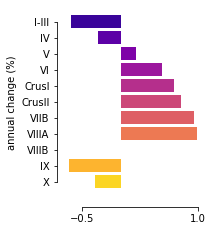

In [12]:
data = copy.deepcopy(dev)
linear_coef = linear_fit(data, num_str_col)
k = linear_coef['k']
pct = linear_coef['k'] / linear_coef['b'] * 100
# plot

_, ax = plt.subplots(figsize=[2.5,3.5])
ax.barh(lobule_name[::-1], pct[::-1], color=palette_cb[::-1])
ax.set_ylabel('annual change (%)')
ax.set_xlim((-0.7, 1.1))
ax.set_xticks([-0.5, 1.0])
sns.despine(offset=10, trim=True)
# stats
# linear regression

stats_results = pd.DataFrame(data.columns[:-num_str_col].values, columns=['lobule'])
for lobule in stats_results['lobule']:
    lobule_data = copy.deepcopy(data[[lobule, 'Age_in_months']])
    lobule_data.dropna(inplace=True)
    X = stats.zscore(lobule_data['Age_in_months'] / 12)
    y = stats.zscore(lobule_data[lobule])
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    fit = model.fit()
    stats_results.loc[stats_results['lobule']==lobule, ['coef', 'r2-adj', 'F', 'p']] = [
        fit.params[-1], fit.rsquared_adj, fit.fvalue, fit.f_pvalue]   

print(stats_results)

<ipython-input-13-2a5a3c18ce18>:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  grad1 = nib.load(grad1_path).get_data()[...,None].reshape(-1, 1)
<ipython-input-13-2a5a3c18ce18>:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  grad2 = nib.load(grad2_path).get_data()[...,None].reshape(-1, 1)
<ipython-input-13-2a5a3c18ce18>:29: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavio

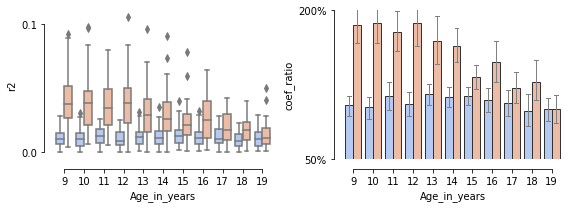

In [13]:
# %% correspondance with rsfmri gradient
# set_path
index = 't1wT2wRatio'
atlas_cb = 'cb_acapulco_adult-2mm'

grad1_path = os.path.join(atlas_dir, 'rsfmri_gradients', 'result_cerebellumonly_gradient1_nifti.nii')
grad2_path = os.path.join(atlas_dir, 'rsfmri_gradients', 'result_cerebellumonly_gradient2_nifti.nii')

voxel_dev_path = os.path.join(results_dir, index, 'HCP-D', f'{index}_{atlas_cb}_voxel.nii.gz')
sub_dev_path = os.path.join(results_dir, index,'HCP-D', f'{index}_{atlas_cb}_voxel_sub')

# sub_info merge
sub_dev = pd.read_table(sub_dev_path, header=None, sep='_', names=['Sub'], usecols=[0], dtype={'Sub':np.str})
sub_info_path = os.path.join(results_dir, 'HCPALL_preproc_subinfo')
sub_info = pd.read_table(sub_info_path, sep='\t', dtype={'Sub':np.str})
sub_info = sub_dev.merge(sub_info, on='Sub', how='left')

# load gradient
grad1 = nib.load(grad1_path).get_fdata()[...,None].reshape(-1, 1)
grad2 = nib.load(grad2_path).get_fdata()[...,None].reshape(-1, 1)

# get mask
mask = np.copy(grad1)[:,0]
mask = mask.astype(np.bool)
grad1 = grad1[mask]
grad2 = grad2[mask]

# voxel data merge
voxel_dev = nib.load(voxel_dev_path).get_fdata()
voxel_dev = voxel_dev.reshape(-1, voxel_dev.shape[-1])
voxel_dev = voxel_dev[mask]

# temp
voxel_suball = np.copy(voxel_dev)
del voxel_dev

#  corr and regression
# ---------------------------
# regression 

import statsmodels.api as sm
from tqdm import tqdm

# r2
r2 = []
with tqdm(total=voxel_suball.shape[-1]) as pbar:
    for i in range(voxel_suball.shape[-1]):
        y = stats.zscore(voxel_suball[:,i])
        X = np.c_[(stats.zscore(grad1), stats.zscore(grad2), stats.zscore(grad1)*stats.zscore(grad2))]
        X = sm.add_constant(X)
        model = sm.OLS(y, X)
        results = model.fit()
        r2.append(results.params[-3:])
        # print(results.summary())
        pbar.update(1)

r2 = (np.asarray(r2).T)**2

reg_df = copy.deepcopy(sub_info)
reg_df['R2_grad1'] = r2[0]
reg_df['R2_grad2'] = r2[1]
reg_df['R2_interact'] = r2[2]

# k
coef = []
with tqdm(total=voxel_suball.shape[-1]) as pbar:
    for i in range(voxel_suball.shape[-1]):
        y = voxel_suball[:,i]
        X = np.c_[(stats.zscore(grad1), stats.zscore(grad2), stats.zscore(grad1)*stats.zscore(grad2))]
        X = sm.add_constant(X)
        model = sm.OLS(y, X)
        results = model.fit()
        coef.append(results.params[-3:])
        # print(results.summary())
        pbar.update(1)

coef = np.asarray(coef).T

reg_df['coef_grad1'] = coef[0]
reg_df['coef_grad2'] = coef[1]
reg_df['coef_interact'] = coef[2]

# 9-19
reg_df = reg_df[reg_df['Age_in_years'] < 20]
reg_df = reg_df[reg_df['Age_in_years'] > 8]

# plot
data = copy.deepcopy(reg_df)
iqr = 3
data.loc[:,data.columns[num_str_col:]] = cb_tools.thr_IQR(
    data.loc[:,data.columns[num_str_col:]].values, times=iqr, series=True)
data = data.dropna()
data_g = data.groupby(['Age_in_years']).mean()

data['coef_grad1_ratio'] = (data['coef_grad1'] / data_g.loc[19, 'coef_grad1']) *100 
data['coef_grad2_ratio'] = (data['coef_grad2'] / data_g.loc[19, 'coef_grad2']) *100

sns.set_palette('coolwarm', n_colors=2)
# # k
# data_stack = pd.melt(data, id_vars=data.columns[:num_str_col], value_vars=['coef_grad1','coef_grad2'], var_name='grad', value_name='coef' )
# sns.boxplot(x='Age_in_years', y='coef', hue='grad', data=data_stack)

# r2
data_stack = pd.melt(data, id_vars=data.columns[:num_str_col], value_vars=['R2_grad1','R2_grad2'], var_name='grad', value_name='r2' )
# k-ratio
data_stack_ratio = pd.melt(data, id_vars=data.columns[:num_str_col], value_vars=['coef_grad1_ratio','coef_grad2_ratio'], var_name='grad', value_name='coef_ratio' )

# plot
fig = plt.figure(figsize=(8,3), tight_layout=True)
gs = gridspec.GridSpec(1, 2)
sns.boxplot(x='Age_in_years', y='r2', hue='grad', data=data_stack, ax=fig.add_subplot(gs[0, 0]))
plt.legend().remove()

sns.barplot(x='Age_in_years', y='coef_ratio', hue='grad', 
            errcolor='gray', errwidth=1, capsize=.2, edgecolor=".2", data=data_stack_ratio,
            ax=fig.add_subplot(gs[0, 1]))
plt.legend().remove()

fig.add_subplot(gs[0, 0]).set_yticks([0, 0.1])
fig.add_subplot(gs[0, 1]).set_ylim([50, 200])
fig.add_subplot(gs[0, 1]).set_yticks([50, 200])
fig.add_subplot(gs[0, 1]).yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
sns.despine(offset=10, trim=True)
plt.legend().remove()

<ipython-input-14-a5e174774935>:26: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if data_sub[key] != []:


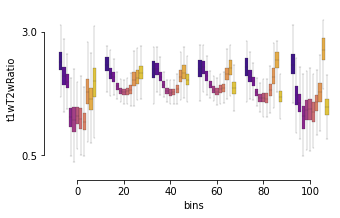

In [14]:
# %% vertical roi
index = 't1wT2wRatio'
dataset = 'HCP-Adult'
atlas_cb_name = 'cb_acapulco_adult-vertical'

# mri_data
save_path_ver = os.path.join(results_dir, index , dataset, f'{index}_{atlas_cb_name}_roi.pckl')
ver_data = pickle.load(open(save_path_ver,'rb'))

# sub_data
result_sub_path = os.path.join(results_dir, index, dataset, f'{index}_{atlas_cb_name}_roi_sub')
result_sub = pd.read_table(result_sub_path, header=None, sep='_', names=['Sub'], usecols=[0], dtype={'Sub':np.str})
sub_info_path = os.path.join(results_dir, f'HCP{dataset.split("-")[-1]}_preproc_subinfo')
sub_info = pd.read_table(sub_info_path, sep='\t', dtype={'Sub':np.str})
sub_info = result_sub.merge(sub_info, on='Sub', how='left')

#%% vertical data norm
num_ver_bins = 6
cutoff = 1  # omit the most median or lateral voxels because of edge effect
fp_col = 2  # 1=mean, 2=median, 3=std, 4=size

ver_data_norm = []
for data_sub in ver_data:
    data_sub_norm = []
    for key in data_sub.keys():
        if data_sub[key] != []:
            xp = data_sub[key][:,0]
            if xp[-1] < xp[0]:
                xp = xp[::-1]
            xp = xp[cutoff:-1*cutoff]
            fp = data_sub[key][:,fp_col][cutoff:-1*cutoff]
            x = np.linspace(xp.min(), xp.max(), num_ver_bins)
            data_sub_norm.append(np.interp(x, xp, fp))
        else:
            data_sub_norm.append(np.repeat(np.nan, num_ver_bins))
    ver_data_norm.append(data_sub_norm)

ver_data_norm = np.asarray(ver_data_norm)
# ver_data_norm_ratio = ver_data_norm / ver_data_norm.mean(-1)[...,None] *100

ver_data_norm_thr = cb_tools.thr_IQR(ver_data_norm, times=1.5, series=True)

# %% lineplot
data = ver_data_norm_thr

data_plot = pd.DataFrame()
for i, key in enumerate(ver_data[0].keys()):
    data_key = pd.DataFrame(data[:,i,:], columns=np.linspace(0,100, num_ver_bins).astype(np.int))
    data_key_stack = data_key.melt(value_vars=data_key.columns, value_name=key, var_name='bins')
    data_plot[key] = data_key_stack[key]
data_plot['bins'] = data_key_stack['bins']
data_plot_g = data_plot.groupby('bins').median()

# plot
data_plot_stack = data_plot.melt(id_vars='bins', value_vars=data_plot.columns[:-1], value_name=index, var_name='name')
data_plot_stack['hemi'] = data_plot_stack['name'].str.split('_').str[-1]
data_plot_stack['roi'] = data_plot_stack['name'].str.split('_').str[0]
data_plot_stack = data_plot_stack.dropna()

_, ax = plt.subplots(figsize=(5,3))
sns.boxplot(x='bins', y=index, hue='roi', palette=palette_cb, data=data_plot_stack, fliersize=0, linewidth=0.2, ax=ax)
plt.legend().remove()
ax.set_yticks([0.5, 3.0])
sns.despine(offset=10, trim=True, ax=ax)

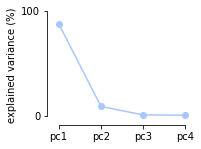

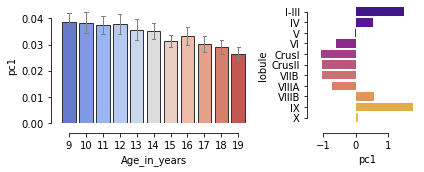

In [15]:
# PCA
from sklearn.decomposition import PCA

# --------------------------------------
# spatial PCA, voxel as sample, sub as feature, explaining intersub covariance from voxel pattern variance
# whole-map
pc_var = 4
data_fit = copy.deepcopy(dev)
data_trans = copy.deepcopy(dev)

pca = PCA(n_components=pc_var, whiten=True)
pca.fit(data_fit.iloc[:,:-num_str_col].T)
n_pc = pca.n_components_
pc_name = ['pc' + str(i+1) for i in range(n_pc)]

# print(pca.explained_variance_ratio_)
plt.figure(figsize=(2.5,2))
plt.plot(['pc'+str(i+1) for i in range(n_pc)], pca.explained_variance_ratio_*100, marker='o')
plt.ylabel('explained variance (%)')
plt.yticks((0, 100))
sns.despine(offset=5, trim=True)

# plot
eigenvec = pd.DataFrame(pca.components_.T, columns=pc_name)
eigenvec.iloc[:,:] = cb_tools.thr_IQR(eigenvec.values, times=1.5, series=True)
eigenvec = pd.concat((eigenvec, data_trans.iloc[:,-num_str_col:]), axis=1)

#
n_pc = 1
fig = plt.figure(figsize=(6,n_pc*2.5), tight_layout=True)
gs = gridspec.GridSpec(n_pc, 5)
[sns.barplot(x='Age_in_years', y=eigenvec.columns[i], data=eigenvec, 
            errcolor='gray', errwidth=1, capsize=.2, edgecolor=".2",
            palette='coolwarm', ax=fig.add_subplot(gs[i, :3])) for i in range(n_pc)]

# pc
X = pca.fit_transform(data_trans.iloc[:,:-num_str_col].T)
pc = pd.DataFrame(X, columns=pc_name)

pc.index = lobule_name
[sns.barplot(y=pc.index, x=pc.iloc[:,i], palette=palette_cb, ax=fig.add_subplot(gs[i, -2:])) for i in range(n_pc)]
sns.despine(offset=10, trim=True)